In [1]:
from PIL import Image
from os import listdir
import imageio as iio
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

datapath = './test_dataset/center_crop'
y_path = 'label.txt'
X_path = [f for f in listdir(datapath) if f.endswith('png')]
X_path = sorted(X_path, key=lambda x : int(x.split()[0]))
print(X_path[:10])
y=[]
X=[]

['0 0.png', '1 1.png', '2 1.png', '3 1.png', '4 0.png', '5 0.png', '6 1.png', '7 1.png', '8 0.png', '9 1.png']


In [2]:
with open(f'{datapath}/{y_path}','r') as label_txt:
    y=list(map(lambda x: int(x.split()[0]),label_txt.readlines()))
    le = LabelEncoder()
    y = le.fit_transform(y)
    label_txt.close()

1000 datas


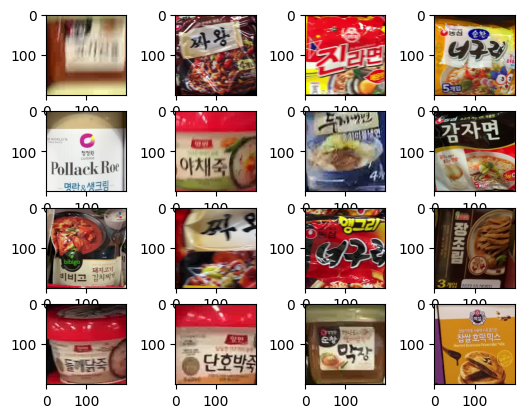

In [3]:

for i in range(len(X_path)):
    img_path = X_path[i]
    img_data=np.zeros((200,200,3))
    img = np.asarray(Image.open(f'{datapath}/{img_path}'))
    ih, iw = img.shape[:2]
    img_data[100-ih//2:100-ih//2+ih,100-iw//2:100-iw//2+iw]=img/255
    X.append(img_data)

fig,axs = plt.subplots(4,4)
for i in range(16):
    axs[i//4,i%4].imshow(X[i])
print(f'{len(X)} datas')

In [4]:
X = np.asarray(X)
y= np.asarray(y)
train_images, test_images, train_labels, test_labels = train_test_split(X,y, test_size=0.2,random_state=42)


In [15]:
from sklearn.model_selection import cross_val_score
from keras.models import Sequential
from keras.layers import Dense, BatchNormalization, Dropout, Conv2D, MaxPooling2D, Flatten, GlobalMaxPooling2D
from keras.optimizers import Adam, SGD, RMSprop, Adadelta, Adagrad, Adamax, Nadam, Ftrl
from keras.callbacks import EarlyStopping, ModelCheckpoint
from scikeras.wrappers import KerasClassifier
from math import floor
from sklearn.metrics import make_scorer, accuracy_score,f1_score
from bayes_opt import BayesianOptimization
from sklearn.model_selection import StratifiedKFold, KFold
from keras.layers import LeakyReLU
from keras.callbacks import CSVLogger
score_acc = make_scorer(accuracy_score)
LeakyReLU = LeakyReLU(alpha=0.1)
import warnings
warnings.filterwarnings('ignore')

C:\Users\leeyu\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


In [11]:
#이전에 돌려서 얻은 하이퍼파라미터들
#수정함
params_nn={}
params_nn['activation'] = 'relu'
params_nn['epochs'] = 20
params_nn['layers1'] = 11
params_nn['layers2'] = 13
params_nn['layers3'] = 76
params_nn['layers4'] = 55
params_nn['learning_rate'] = 0.225886505284512
params_nn['optimizer'] = 'adam'
params_nn['pooling_size'] = 5
params_nn['dropout_prob'] = 0.2136
params_nn['dropout_rate'] = 0.08933


In [17]:
def optimized_model3():
  model = models.Sequential()
  model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(200, 200,3)))
  model.add(MaxPooling2D(pool_size=(3,3)))
  model.add(Dropout(params_nn['dropout_rate'], seed=123))
  model.add(Conv2D(32, (3, 3), activation='relu'))
  model.add(MaxPooling2D(pool_size=(3,3)))
  model.add(Dropout(params_nn['dropout_rate'], seed=123))
  model.add(Conv2D(32, (3, 3), activation='relu'))
  model.add(MaxPooling2D(pool_size=(3,3)))
  model.add(Dropout(params_nn['dropout_rate'], seed=123))
  model.add(GlobalMaxPooling2D())
  model.add(Dense(params_nn['layers3'], activation=params_nn['activation']))
  model.add(Dropout(params_nn['dropout_rate'], seed=123))
  model.add(layers.Dense(params_nn['layers4'], activation=params_nn['activation']))
  model.add(Dense(50,activation='relu'))
  model.add(Dropout(params_nn['dropout_rate'], seed=123))
  model.add(Dense(50,activation='relu'))
  model.add(Dense(1, activation='sigmoid'))
  model.compile(optimizer=params_nn['optimizer'],
                loss='binary_crossentropy',
                metrics=['accuracy'])
  return model

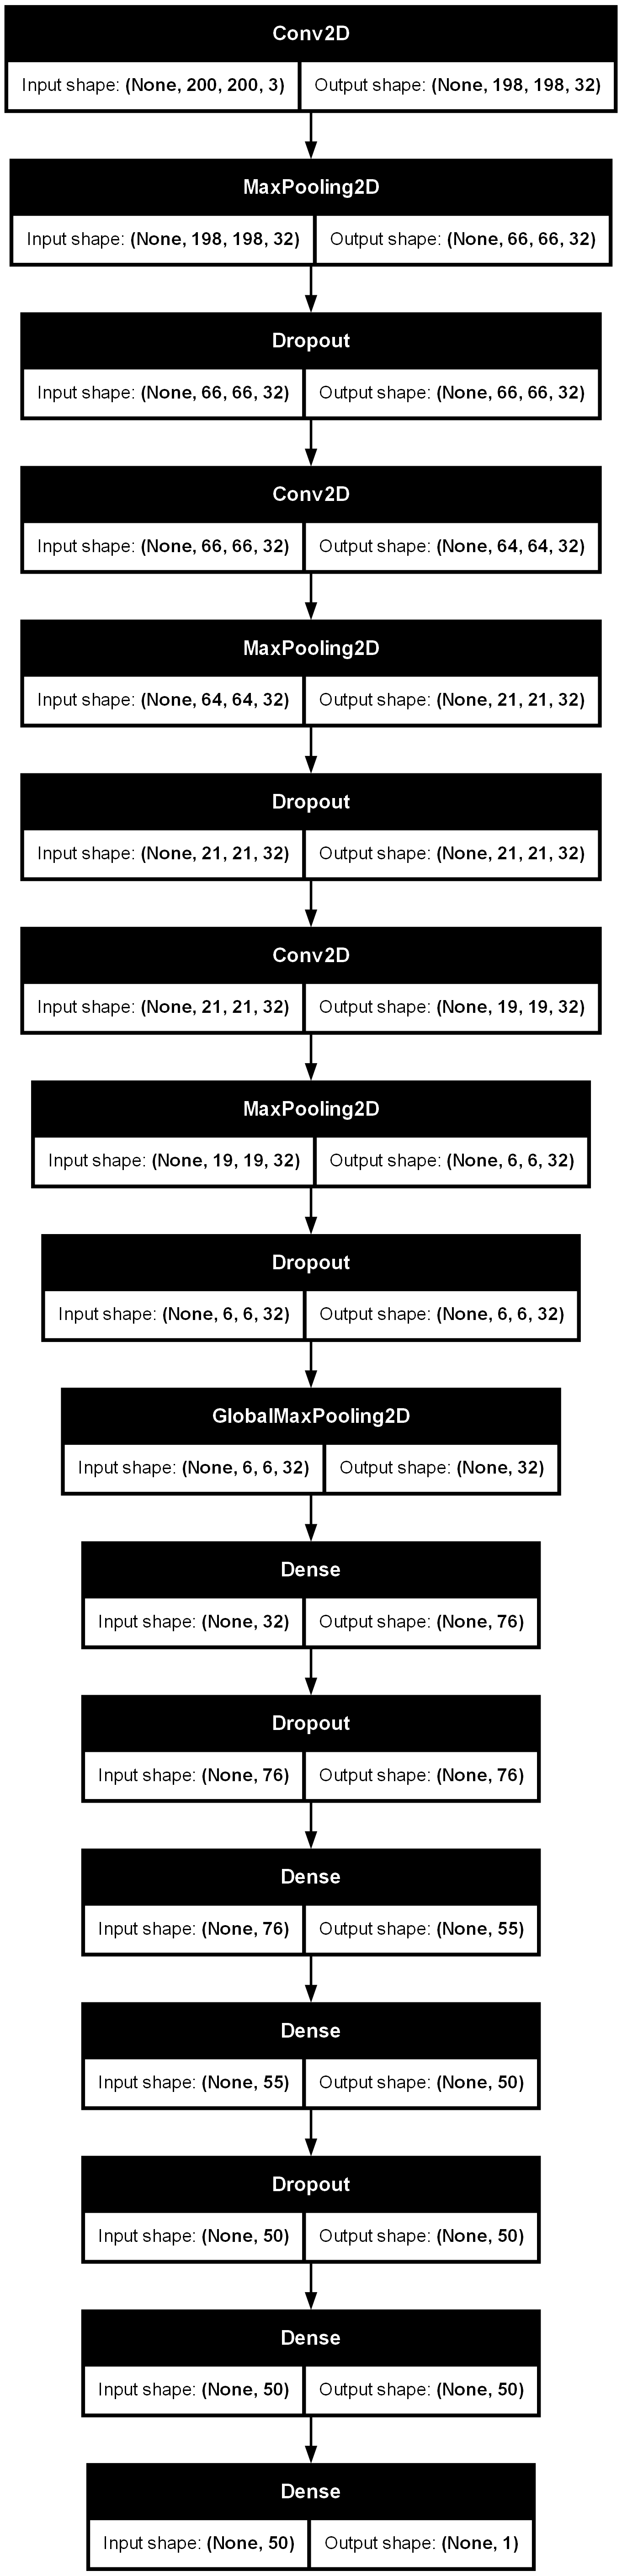

In [18]:
from tensorflow.keras.utils import plot_model
model = optimized_model3()
plot_model(model, to_file='model.png', show_shapes=True)

# Center crop

In [19]:

es = EarlyStopping(monitor='accuracy', mode='max', verbose=0, patience=20)
nn = KerasClassifier(build_fn=optimized_model3, epochs=params_nn['epochs'], batch_size=200,
                         verbose=0)
nn.fit(train_images, train_labels, validation_data=(test_images, test_labels), verbose=1)
# model.fit(train_images,train_labels,epochs=params_nn['epochs'])
y_predict =nn.predict(test_images, verbose=None)
print(f"""Center-cropped Image
Accuracy : {accuracy_score(test_labels, y_predict)}
F1 Score : {f1_score(test_labels, y_predict, average=None)}
""")


Epoch 1/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.5558 - loss: 0.6895 - val_accuracy: 0.6400 - val_loss: 0.6739
Epoch 2/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 641ms/step - accuracy: 0.5303 - loss: 0.6876 - val_accuracy: 0.6400 - val_loss: 0.6721
Epoch 3/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 604ms/step - accuracy: 0.5425 - loss: 0.6780 - val_accuracy: 0.6400 - val_loss: 0.6588
Epoch 4/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 554ms/step - accuracy: 0.5322 - loss: 0.6693 - val_accuracy: 0.6400 - val_loss: 0.6243
Epoch 5/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 561ms/step - accuracy: 0.5492 - loss: 0.6417 - val_accuracy: 0.8600 - val_loss: 0.6037
Epoch 6/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 578ms/step - accuracy: 0.6840 - loss: 0.5959 - val_accuracy: 0.8850 - val_loss: 0.5177
Epoch 7/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 607ms/step - accuracy: 0.8123 - loss: 0.5133 - val_accuracy: 0.8500 - val_loss: 0.4636
Epoch 8/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 595ms/step - accuracy: 0.8753 - loss: 0.4162 - val_accuracy: 0.8400 - val_loss: 0.

# Padding

1000
1000 data


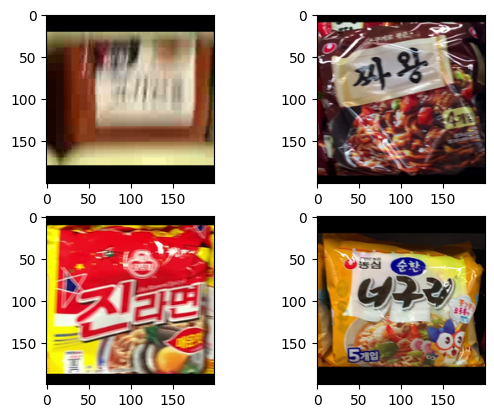

In [21]:
datapath = './test_dataset/padding'
X_path = [f for f in listdir(datapath) if f.endswith('png')]
X_path = sorted(X_path, key=lambda x : int(x.split()[0]))
padding_y=[]
padding_X=[]
#target 레이블 저장
with open(f'{datapath}/{y_path}','r') as label_txt:
    padding_y=list(map(lambda x: int(x.split()[0]),label_txt.readlines()))
    le = LabelEncoder()
    padding_y = le.fit_transform(padding_y)
    label_txt.close()
print(len(X_path))
for i in range(len(X_path)):
    img_path = X_path[i]
    img_data=np.zeros((200,200,3))
    img = np.asarray(Image.open(f'{datapath}/{img_path}'))
    ih, iw = img.shape[:2]
    img_data[100-ih//2:100+ih-ih//2,100-iw//2:100+iw-iw//2]=img/255
    padding_X.append(img_data)

fig,axs = plt.subplots(2,2)
for i in range(4):
    axs[i//2,i%2].imshow(padding_X[i])
print(f'{len(padding_X)} data')
padding_X = np.asarray(padding_X)
padding_y = np.asarray(padding_y)

In [22]:
p_train_images, p_test_images, p_train_labels, p_test_labels = train_test_split(padding_X,padding_y,test_size = 0.2, random_state=42)

In [23]:
print(len(p_train_images))

800


In [24]:
# model = optimized_model2()
es = EarlyStopping(monitor='accuracy', mode='max', verbose=0, patience=20)
nn = KerasClassifier(build_fn=optimized_model3, epochs=params_nn['epochs'], batch_size=200,
                         verbose=0)
history=nn.fit(p_train_images, p_train_labels, validation_data=(p_test_images, p_test_labels), verbose=1,
               callbacks=[CSVLogger('asd.log', append=True)]
              )
# model.fit(train_images,train_labels, epochs = 15)
# y_predict = np.argmax(model.predict(test_images, verbose=None),axis=1)
y_predict=nn.predict(p_test_images, verbose=None)
print(f"""Padding Image
Accuracy : {accuracy_score(p_test_labels, y_predict)}
F1 Score : {f1_score(p_test_labels, y_predict, average=None)}
""")


Epoch 1/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.4790 - loss: 0.7018 - val_accuracy: 0.6400 - val_loss: 0.6818
Epoch 2/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 600ms/step - accuracy: 0.5422 - loss: 0.6869 - val_accuracy: 0.6400 - val_loss: 0.6701
Epoch 3/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 538ms/step - accuracy: 0.5398 - loss: 0.6816 - val_accuracy: 0.6400 - val_loss: 0.6571
Epoch 4/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 560ms/step - accuracy: 0.5377 - loss: 0.6691 - val_accuracy: 0.6400 - val_loss: 0.6338
Epoch 5/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 579ms/step - accuracy: 0.5407 - loss: 0.6460 - val_accuracy: 0.7350 - val_loss: 0.5902
Epoch 6/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 592ms/step - accuracy: 0.6138 - loss: 0.5920 - val_accuracy: 0.8450 - val_loss: 0.5357
Epoch 7/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 596ms/step - accuracy: 0.8082 - loss: 0.5308 - val_accuracy: 0.8600 - val_loss: 0.4569
Epoch 8/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 607ms/step - accuracy: 0.8792 - loss: 0.4388 - val_accuracy: 0.8500 - val_loss: 0.

padding이 정확도가 더 높다
# 기타 분석

In [5]:
sum(y)/len(y)

0.56

데이터에서 학습된 데이터의 label별 균형이 균일하다. 데이터 불균형에 대해서는 고민할 필요 없을 거 같다.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


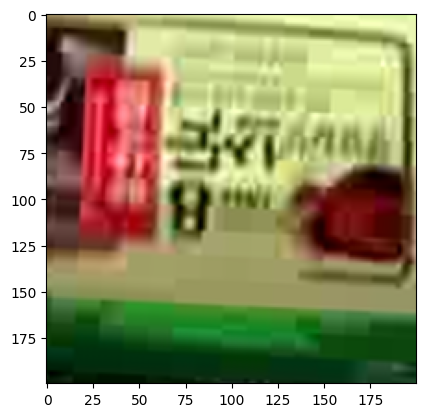

In [8]:
import keras
from keras.layers import RandomFlip, RandomRotation, RandomContrast, RandomCrop, RandomZoom
data_augmentation = keras.Sequential([
    RandomFlip('horizontal_and_vertical'),
    RandomRotation(0.01),
    RandomContrast(0.3),
    RandomZoom(0.2)
])
aug_img = data_augmentation(train_images)
plt.imshow(aug_img[0])

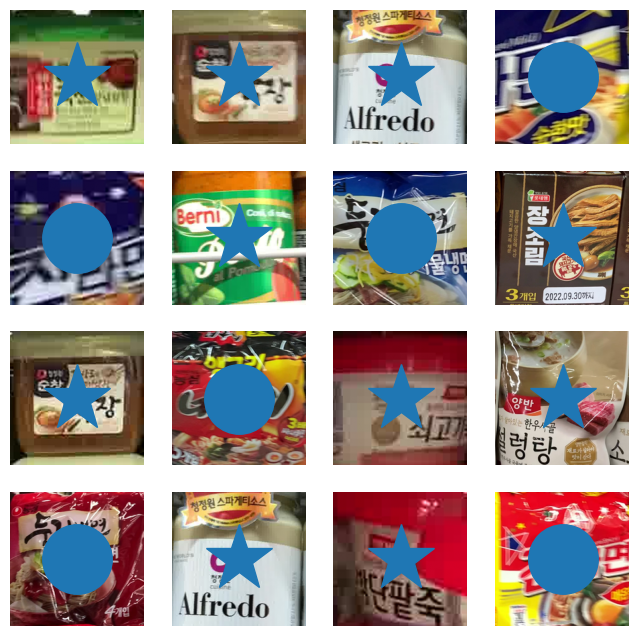

In [6]:
grid_size = 4
fig, ax = plt.subplots(grid_size,grid_size, figsize=(8,8))
for i in range(grid_size**2):
    cax=ax[i%grid_size, i//grid_size]
    cax.axis('off')
    cax.imshow(train_images[i])
    cax.plot(100,100,'*' if train_labels[i] == 0 else 'o',markersize=50)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

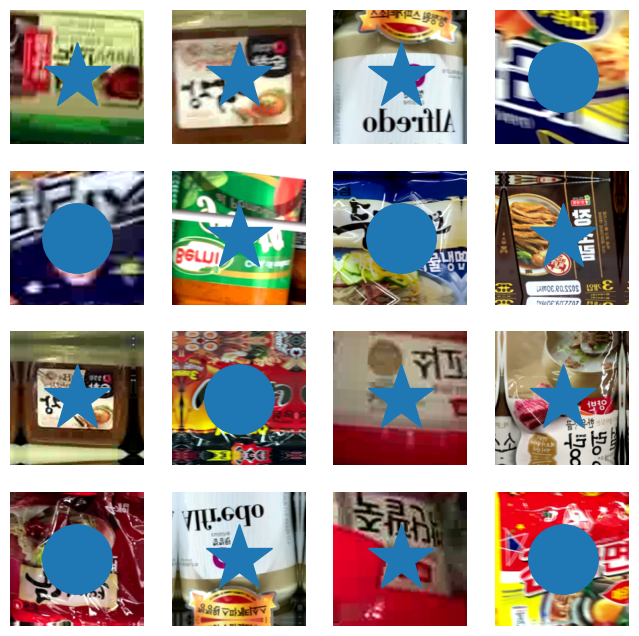

In [10]:
grid_size = 4
fig, ax = plt.subplots(grid_size,grid_size, figsize=(8,8))
for i in range(grid_size**2):
    cax=ax[i%grid_size, i//grid_size]
    cax.axis('off')
    cax.imshow(aug_img[i])
    cax.plot(100,100,'*' if train_labels[i] == 0 else 'o',markersize=50)

In [48]:
new_ds = np.concatenate((train_images, aug_img.numpy()), axis=0)
new_label = np.concatenate((y,y), axis=0)
print(len(new_ds), len(train_images), len(aug_img))

1600 800 800


(200, 200, 3)


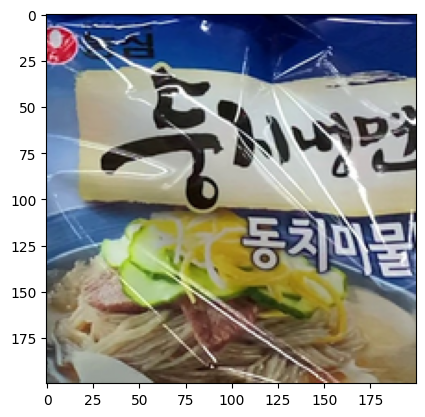

In [60]:
plt.imshow(train_images[3])
print(train_images[3].shape)

In [ ]:
# model = optimized_model2()
es = EarlyStopping(monitor='accuracy', mode='max', verbose=0, patience=20)
nn = KerasClassifier(build_fn=optimized_model3, epochs=params_nn['epochs'], batch_size=200,
                         verbose=0)
history=nn.fit(p_train_images, p_train_labels, validation_data=(p_test_images, p_test_labels), verbose=1,
               callbacks=[CSVLogger('asd.log', append=True)]
              )
# model.fit(train_images,train_labels, epochs = 15)
# y_predict = np.argmax(model.predict(test_images, verbose=None),axis=1)
y_predict=nn.predict(p_test_images, verbose=None)
print(f"""Image Augmented
Accuracy : {accuracy_score(p_test_labels, y_predict)}
F1 Score : {f1_score(p_test_labels, y_predict, average=None)}
""")
